In [1]:
"""The content of process_data.py"""

from collections import Counter
import random
import os
import sys
sys.path.append('..')
import zipfile

import numpy as np
from six.moves import urllib
import tensorflow as tf


# Parameters for downloading data
DOWNLOAD_URL = 'http://mattmahoney.net/dc/'
EXPECTED_BYTES = 31344016
DATA_FOLDER = 'data/'
FILE_NAME = 'text8.zip'


def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
    	pass

def download(file_name, expected_bytes):
    """ Download the dataset text8 if it's not already downloaded """
    file_path = DATA_FOLDER + file_name
    if os.path.exists(file_path):
        print("Dataset ready")
        return file_path
    file_name, _ = urllib.request.urlretrieve(DOWNLOAD_URL + file_name, file_path)
    file_stat = os.stat(file_path)
    if file_stat.st_size == expected_bytes:
        print('Successfully downloaded the file', file_name)
    else:
        raise Exception(
              'File ' + file_name +
              ' might be corrupted. You should try downloading it with a browser.')
    return file_path    
    
    
def read_data(file_path):
    """ Read data into a list of tokens"""
    with zipfile.ZipFile(file_path) as f:
        words = tf.compat.as_str(f.read(f.namelist()[0])).split()
        # tf.compat.as_str() converts the input into the string
    return words

def build_vocab(words, vocab_size):
    """ Build vocabulary of VOCAB_SIZE most frequent words """
    dictionary = dict()
    count = [('UNK', -1)]
    count.extend(Counter(words).most_common(vocab_size - 1))
    index = 0
    make_dir('processed')
    with open('processed/vocab_1000.tsv', "w") as f:
        for word, _ in count:
            dictionary[word] = index
            if index < 1000:
                f.write(word + "\n")
            index += 1
    index_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, index_dictionary

def convert_words_to_index(words, dictionary):
    """ Replace each word in the dataset with its index in the dictionary """
    return [dictionary[word] if word in dictionary else 0 for word in words]

def generate_sample(index_words, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index, center in enumerate(index_words):
        context = random.randint(1, context_window_size)
        center = index_words[index]
        word_before = index_words[max(index - 1, 0)]
        word_after = index_words[index + 1]
        yield center, word_before, word_after

def get_batch(iterator, batch_size, window_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 2])
     
        for index in range(batch_size):
             center_batch[index], target_batch[index][0] , target_batch[index][1] = next(iterator)
        yield center_batch, target_batch
        
def get_batch_gen(index_words, context_window_size, batch_size):
    """ Return a python generator that generates batches"""
    single_gen = generate_sample(index_words, context_window_size)
    batch_gen = get_batch(single_gen, batch_size, context_window_size)
    return batch_gen
        
def process_data(vocab_size):
    """ Read data, build vocabulary and dictionary"""
    file_path = download(FILE_NAME, EXPECTED_BYTES)
    words = read_data(file_path)
    dictionary, index_dictionary = build_vocab(words, vocab_size)
    index_words = convert_words_to_index(words, dictionary)
    del words # to save memory
    return index_words, dictionary, index_dictionary

In [2]:
vocab_size = 10000
window_sz = 1
batch_sz = 64
index_words, dictionary, index_dictionary = process_data(vocab_size)
batch_gen = get_batch_gen(index_words, window_sz, batch_sz)
X, y = next(batch_gen)

print(X.shape)
print(y.shape)

Dataset ready
(64,)
(64, 2)


In [3]:
for i in range(10): # print out the pairs
  data = index_dictionary[X[i]]
  label = index_dictionary[y[i,0]]
  print(X[i], y[i,0], y[i,1])
  print('(', data, label,')')

5236 5236.0 3081.0
( anarchism anarchism )
3081 5236.0 12.0
( originated anarchism )
12 3081.0 6.0
( as originated )
6 12.0 195.0
( a as )
195 6.0 2.0
( term a )
2 195.0 3135.0
( of term )
3135 2.0 46.0
( abuse of )
46 3135.0 59.0
( first abuse )
59 46.0 156.0
( used first )
156 59.0 128.0
( against used )


In [4]:
from __future__ import absolute_import # use absolute import instead of relative import

# '/' for floating point division, '//' for integer division
from __future__ import division  
from __future__ import print_function  # use 'print' as a function

import os

import numpy as np
import tensorflow as tf


#from process_data import make_dir, get_batch_gen, process_data

class SkipGramModel:
  """ Build the graph for word2vec model """
  def __init__(self, hparams=None):

    if hparams is None:
        self.hps = get_default_hparams()
    else:
        self.hps = hparams

    # define a variable to record training progress
    self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
    

  def _create_input(self):
    """ Step 1: define input and output """

    with tf.name_scope("data"):
      self.targets = tf.placeholder(tf.int32, [self.hps.num_pairs, ], name='targets')
      self.neighbors = tf.placeholder(tf.int32, [self.hps.num_pairs, 2], name='neighbors')
      dataset = tf.contrib.data.Dataset.from_tensor_slices((self.targets, self.neighbors))
      dataset = dataset.repeat() # # Repeat the input indefinitely
      dataset = dataset.batch(self.hps.batch_size)
      
        
      self.iterator = dataset.make_initializable_iterator()  # create iterator
      self.target_words, self.neighbors_words = self.iterator.get_next()

  def _create_embedding(self):
    """ Step 2: define weights. 
        In word2vec, it's actually the weights that we care about
    """
    with tf.device('/gpu:0'):
      with tf.name_scope("embed"):
        self.embed_matrix = tf.Variable(
                              tf.random_uniform([self.hps.vocab_size,
                                                 self.hps.embed_size], -1.0, 1.0),
                                                 name='embed_matrix')

  def _create_loss(self):
    """ Step 3 + 4: define the model + the loss function """
    with tf.device('/cpu:0'):
      with tf.name_scope("loss"):
        # Step 3: define the inference
        embed_before = tf.nn.embedding_lookup(self.embed_matrix, self.neighbors_words[:,0])
        embed_after = tf.nn.embedding_lookup(self.embed_matrix, self.neighbors_words[:,1])
        #embed = (embed_before + embed_after)/2
        embed = tf.div((embed_before + embed_after), 2)


        # Step 4: define loss function
        # construct variables for NCE loss
        nce_weight = tf.Variable(
                        tf.truncated_normal([self.hps.vocab_size, self.hps.embed_size],
                                            stddev=1.0 / (self.hps.embed_size ** 0.5)),
                                            name='nce_weight')
        nce_bias = tf.Variable(tf.zeros([self.hps.vocab_size]), name='nce_bias')
        self.target_words = tf.reshape(self.target_words, (-1, 1))

        # define loss function to be NCE loss function
        self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                  biases=nce_bias,
                                                  labels=self.target_words,
                                                  inputs= embed,
                                                  num_sampled=self.hps.num_sampled,
                                                  num_classes=self.hps.vocab_size), name='loss')
  def _create_optimizer(self):
    """ Step 5: define optimizer """
    with tf.device('/gpu:0'):
      self.optimizer = tf.train.AdamOptimizer(self.hps.lr).minimize(self.loss,
                                                         global_step=self.global_step)
  
  def _build_nearby_graph(self):
    # Nodes for computing neighbors for a given word according to
    # their cosine distance.
    self.nearby_word = tf.placeholder(dtype=tf.int32)  # word id
    nemb = tf.nn.l2_normalize(self.embed_matrix, 1)
    nearby_emb = tf.gather(nemb, self.nearby_word)
    nearby_dist = tf.matmul(nearby_emb, nemb, transpose_b=True)
    self.nearby_val, self.nearby_idx = tf.nn.top_k(nearby_dist,
                                         min(1000, self.hps.vocab_size))
    

  def _build_eval_graph(self):
    """Build the eval graph."""
    # Eval graph

    # Each analogy task is to predict the 4th word (d) given three
    # words: a, b, c.  E.g., a=italy, b=rome, c=france, we should
    # predict d=paris.

    # The eval feeds three vectors of word ids for a, b, c, each of
    # which is of size N, where N is the number of analogies we want to
    # evaluate in one batch.
    self.analogy_a = tf.placeholder(dtype=tf.int32)  # [N]
    self.analogy_b = tf.placeholder(dtype=tf.int32)  # [N]
    self.analogy_c = tf.placeholder(dtype=tf.int32)  # [N]

    # Normalized word embeddings of shape [vocab_size, emb_dim].
    nemb = tf.nn.l2_normalize(self.embed_matrix, 1)

    # Each row of a_emb, b_emb, c_emb is a word's embedding vector.
    # They all have the shape [N, emb_dim]
    a_emb = tf.gather(nemb, self.analogy_a)  # a's embs
    b_emb = tf.gather(nemb, self.analogy_b)  # b's embs
    c_emb = tf.gather(nemb, self.analogy_c)  # c's embs

    # We expect that d's embedding vectors on the unit hyper-sphere is
    # near: c_emb + (b_emb - a_emb), which has the shape [N, emb_dim].
    target = c_emb + (b_emb - a_emb)

    # Compute cosine distance between each pair of target and vocab.
    # dist has shape [N, vocab_size].
    dist = tf.matmul(target, nemb, transpose_b=True)

    # For each question (row in dist), find the top 20 words.
    _, self.pred_idx = tf.nn.top_k(dist, 20)

  def predict(self, sess, analogy):
    """ Predict the top 20 answers for analogy questions """
    idx, = sess.run([self.pred_idx], {
        self.analogy_a: analogy[:, 0],
        self.analogy_b: analogy[:, 1],
        self.analogy_c: analogy[:, 2]
    })
    return idx

  def _create_summaries(self):
    with tf.name_scope("summaries"):
      tf.summary.scalar("loss", self.loss)
      tf.summary.histogram("histogram_loss", self.loss)
      # because you have several summaries, we should merge them all
      # into one op to make it easier to manage
      self.summary_op = tf.summary.merge_all()


  def build_graph(self):
    """ Build the graph for our model """
    self._create_input()
    self._create_embedding()
    self._create_loss()
    self._create_optimizer()
    self._build_eval_graph()
    self._build_nearby_graph()
    self._create_summaries()



def train_model(sess, model, batch_gen, index_words, num_train_steps):
  saver = tf.train.Saver()
  # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

  initial_step = 0
  make_dir('checkpoints') # directory to store checkpoints


  
  sess.run(tf.global_variables_initializer()) # initialize all variables
  ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
  # if that checkpoint exists, restore from checkpoint
  if ckpt and ckpt.model_checkpoint_path:
      saver.restore(sess, ckpt.model_checkpoint_path)

  total_loss = 0.0 # use this to calculate late average loss in the last SKIP_STEP steps
  writer = tf.summary.FileWriter('graph/lr' + str(model.hps.lr), sess.graph)
  initial_step = model.global_step.eval()
  for index in range(initial_step, initial_step + num_train_steps):
    # feed in new dataset  
    if index % model.hps.new_dataset_every == 0:
      try:
          targets, neighbors = next(batch_gen)
      except StopIteration: # generator has nothing left to generate
          batch_gen = get_batch_gen(index_words, 
                                    model.hps.skip_window, 
                                    model.hps.num_pairs)
          targets, neighbors = next(batch_gen)
          print('Finished looking at the whole text')
            
      feed = {
          model.targets: targets,
          model.neighbors: neighbors
      }
      _ = sess.run(model.iterator.initializer, feed_dict = feed)
      print('feeding in new dataset')
      
      
    loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op])
    writer.add_summary(summary, global_step=index)
    total_loss += loss_batch
    if (index + 1) % model.hps.skip_step == 0:
        print('Average loss at step {}: {:5.1f}'.format(
                                                  index,
                                                  total_loss/model.hps.skip_step))
        total_loss = 0.0
        saver.save(sess, 'checkpoints/skip-gram', index)


def get_default_hparams():
    hparams = tf.contrib.training.HParams(
        num_pairs = 10**6,                # number of (center, target) pairs 
                                          # in each dataset instance
        vocab_size = 10000,
        batch_size = 300,
        embed_size = 300,                 # dimension of the word embedding vectors
        skip_window = 1,                  # the context window
        num_sampled = 100,                # number of negative examples to sample
        lr = 0.005,                       # learning rate
        new_dataset_every = 10**4,        # replace the original dataset every ? steps
        num_train_steps = 1*10**5,        # number of training steps for each feed of dataset
        skip_step = 2000
    )
    return hparams

def main():

  hps = get_default_hparams()
  index_words, dictionary, index_dictionary = process_data(hps.vocab_size)
  batch_gen = get_batch_gen(index_words, hps.skip_window, hps.num_pairs)
                                                          
  model = SkipGramModel(hparams = hps)
  model.build_graph()
  
  
  with tf.Session() as sess:
    
    # feed the model with dataset
    targets, neighbors = next(batch_gen)
    print(targets.shape)
    print(neighbors.shape)
    feed = {
        model.targets: targets,
        model.neighbors: neighbors
        
    }
    sess.run(model.iterator.initializer, feed_dict = feed) # initialize the iterator

    train_model(sess, model, batch_gen, index_words, hps.num_train_steps)
      
if __name__ == '__main__':
  main()

Dataset ready
Instructions for updating:
Use `tf.data.Dataset.from_tensor_slices()`.
(1000000,)
(1000000, 2)
INFO:tensorflow:Restoring parameters from checkpoints/skip-gram-13999
Average loss at step 15999:   7.7
Average loss at step 17999:   6.9
Average loss at step 19999:   5.8
feeding in new dataset
Average loss at step 21999:   7.3
Average loss at step 23999:   6.9
Average loss at step 25999:   5.5
Average loss at step 27999:   5.4
Average loss at step 29999:   5.4
feeding in new dataset
Average loss at step 31999:   7.6
Average loss at step 33999:   7.4
Average loss at step 35999:   5.5
Average loss at step 37999:   5.3
Average loss at step 39999:   5.3
feeding in new dataset
Average loss at step 41999:   7.8
Average loss at step 43999:   7.4
Average loss at step 45999:   5.5
Average loss at step 47999:   5.3
Average loss at step 49999:   5.3
feeding in new dataset
Average loss at step 51999:   7.5
Average loss at step 53999:   7.5
Average loss at step 55999:   5.5
Average loss at

In [7]:
import os
import tensorflow as tf
#from process_data import process_data
#from train import get_default_hparams, SkipGramModel

#Clears the default graph stack and resets the global default graph
tf.reset_default_graph() 
hps = get_default_hparams()
# get dictionary 
index_words, dictionary, index_dictionary = process_data(hps.vocab_size)

# build model
model = SkipGramModel(hps)
model.build_graph()

# initialize variables and restore checkpoint
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
saver.restore(sess, ckpt.model_checkpoint_path)

Dataset ready
INFO:tensorflow:Restoring parameters from checkpoints/skip-gram-113999


In [8]:
import numpy as np

def nearby(words, model, sess, dictionary, index_dictionary, num=10):
    """Prints out nearby words given a list of words."""
    ids = np.array([dictionary.get(x, 0) for x in words])
    vals, idx = sess.run(
        [model.nearby_val, model.nearby_idx], {model.nearby_word: ids})
    for i in range(len(words)):
      print("\n%s\n=====================================" % (words[i]))
      for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
        print("%-20s %6.4f" % (index_dictionary.get(neighbor), distance))
        
def analogy(line, model, sess, dictionary, index_dictionary):
  """ Prints the top k anologies for a given array which contain 3 words"""
  analogy = np.array([dictionary.get(w, 0) for w in line])[np.newaxis,:]
  idx = model.predict(sess, analogy)
  print(line)
  for i in idx[0]:
    print(index_dictionary[i])

In [9]:
words = ['word', 'two', 'vector']
nearby(words, model, sess, dictionary, index_dictionary)


word
word                 1.0000
UNK                  0.5286
term                 0.5215
one                  0.4983
words                0.4977
nine                 0.4956
two                  0.4902
name                 0.4815
seven                0.4791
eight                0.4776

two
two                  1.0000
three                0.8471
four                 0.8344
five                 0.8245
nine                 0.8216
one                  0.8182
six                  0.8072
seven                0.8065
eight                0.7928
zero                 0.7604

vector
vector               1.0000
UNK                  0.4650
x                    0.4462
nine                 0.4304
topological          0.4292
one                  0.4288
five                 0.4155
three                0.4143
notion               0.4121
banach               0.4084


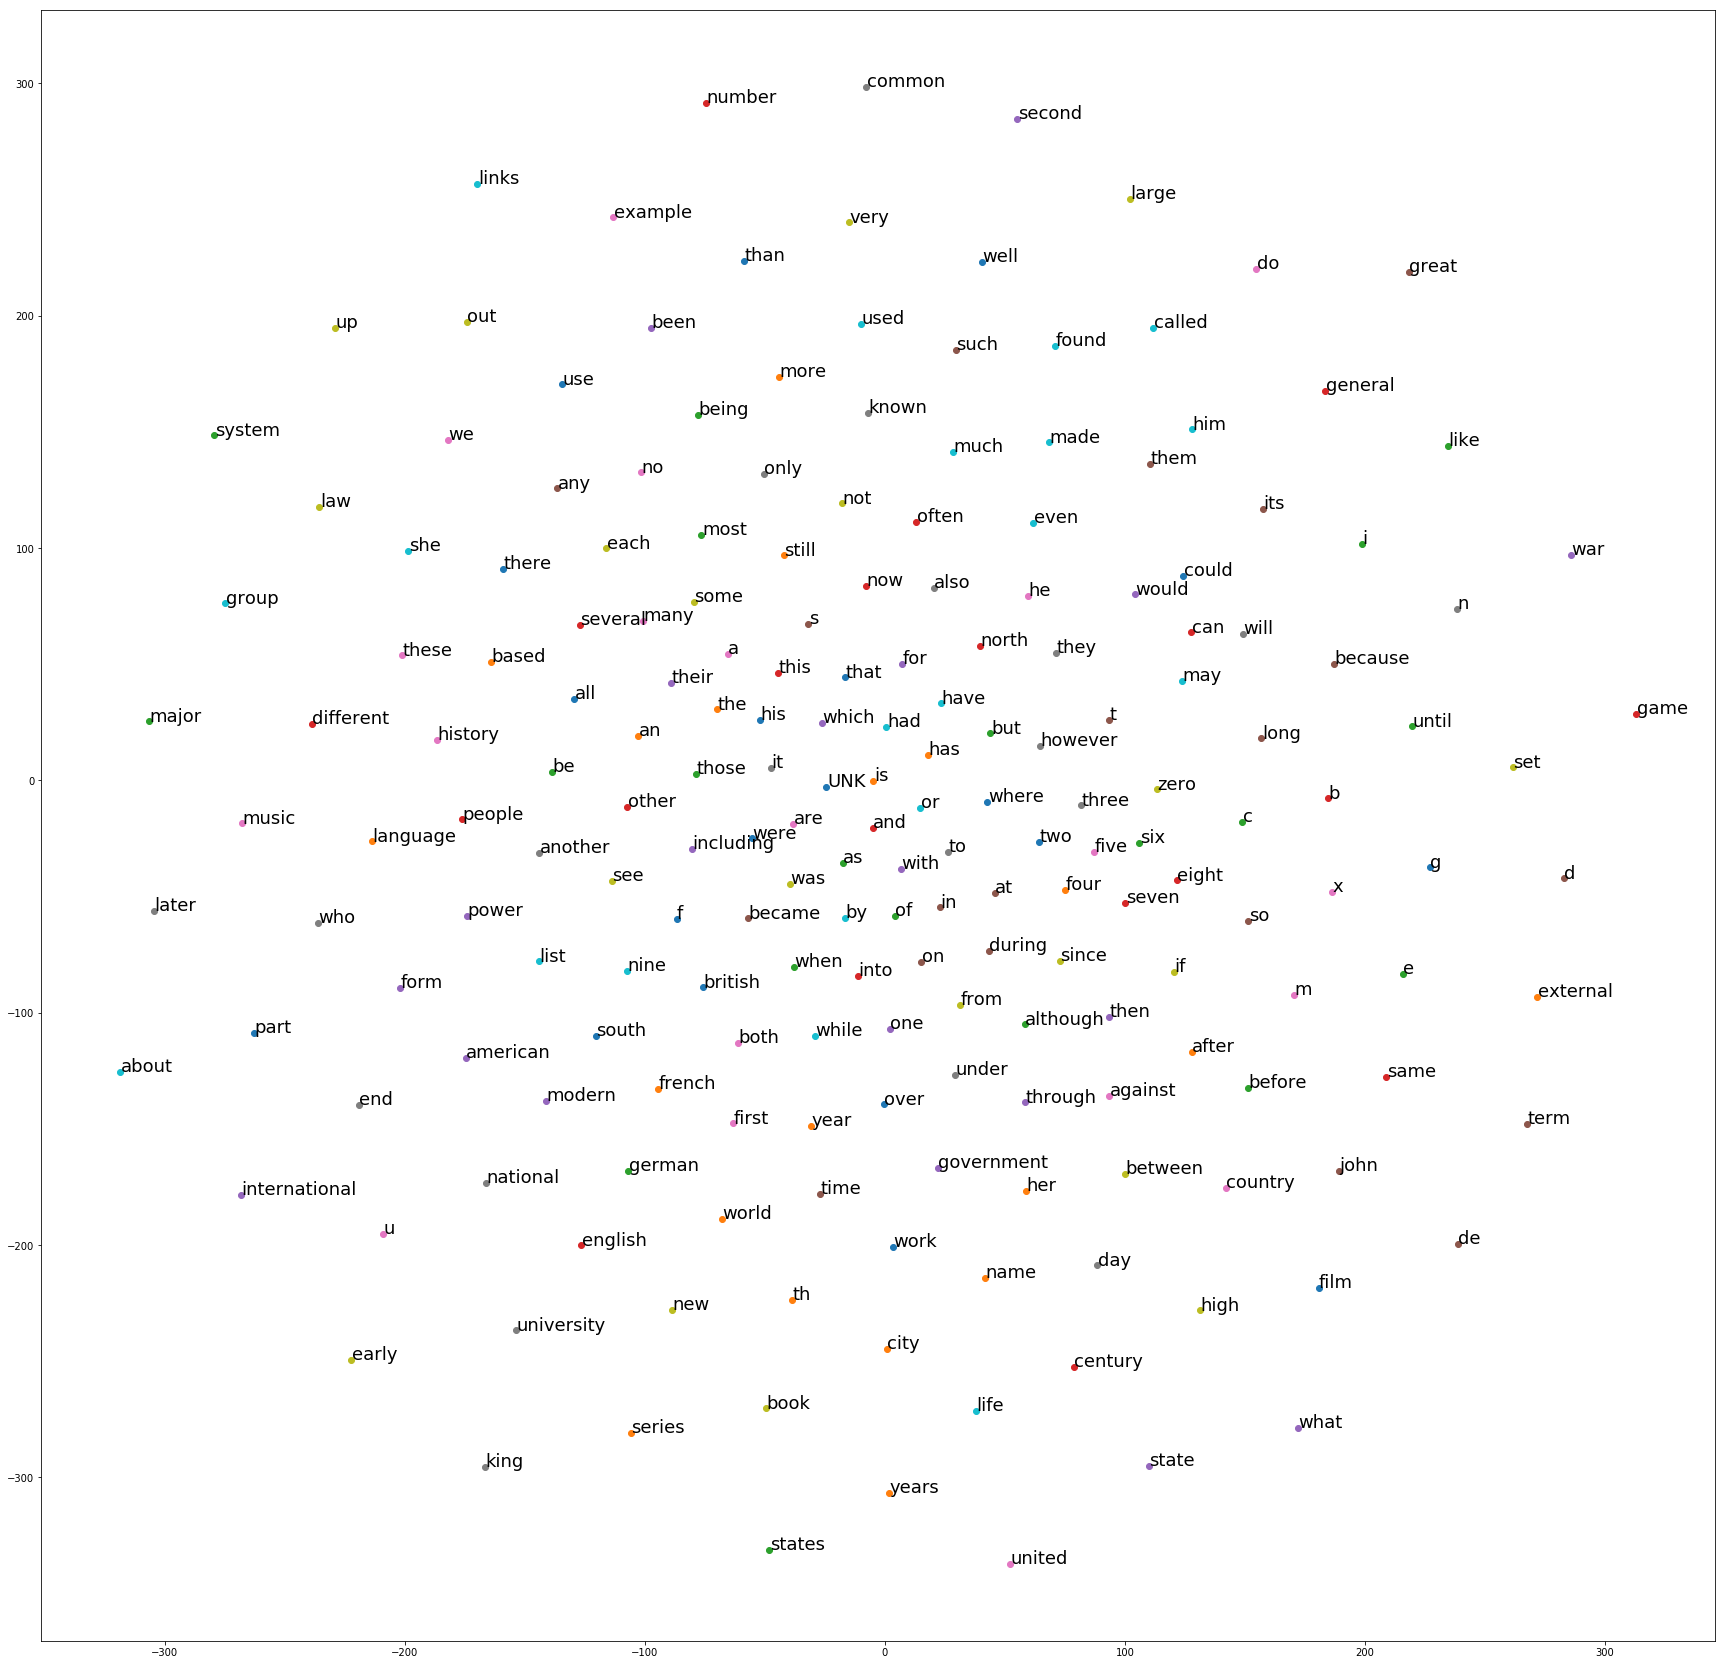

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

rng = 200

embed_matrix = sess.run(model.embed_matrix) # get the embed matrix

X_embedded = TSNE(n_components=2).fit_transform(embed_matrix[:rng])

plt.figure(figsize=(30,30))

for i in range(rng):
  plt.scatter(X_embedded[i][0], X_embedded[i][1])
  plt.text(X_embedded[i][0]+0.2,
           X_embedded[i][1]+0.2,
           index_dictionary.get(i, 0), fontsize=18)
  

plt.show()

## Summary
skip-gram和cbow的差別就在cbow是用兩旁的字來預測中間的字，所以先修改了一開始process_data中的generate_sample和get_batch，將兩旁的字都抓出來（skip-gram中是前面和後面隨機抓一個字），做成batch放進model。要train的時候，將center設為target，將input改成兩邊字embedded weight的average。